In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from embedding_functions import *
from experiment_setup import *
from functions_for_bootstrap import *
import numba as nb
from scipy.stats import wasserstein_distance
from tqdm import tqdm

### Mixed-membership

We want to sample nodes that come from a mixed membership model, i.e. less good clustering. Then want to test how good our bootstraps of nodes look, and apply our KL test to test this formally.

In [8]:
# Code up a mixed membership model 
K=3
n= 300

# use our new function to make a MMSBM
A, largest_prob, P = make_MMSBM(n, K)

A = A.astype(float)
ya = UASE([A], 2)
plot_embedding(ya, n, 1, largest_prob)

This isn't actually community, it is just the one probabilistically they are most likely to belong to

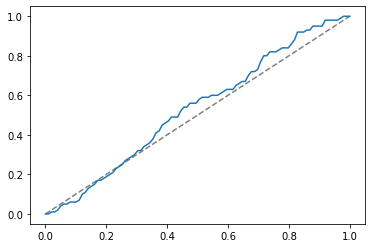

0.04

In [17]:
A_obs = A.copy()
p_vals, A_ests = test_bootstrap(A_obs, K, B=100,n_neighbors=5)
A_est = A_ests[0]

plot_power(p_vals, plot=True)

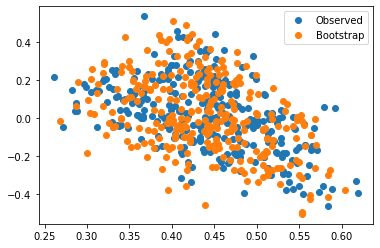

In [18]:
A_res = make_inhomogeneous_rg(P)

yhat_est = UASE([A_obs,A_est, A_res], d=K, flat=False)

plt.plot(yhat_est[0, :, 0], yhat_est[0, :, 1], 'o', label="Observed", alpha=1)
plt.plot(yhat_est[1, :, 0], yhat_est[1, :, 1], 'o', label="Bootstrap", alpha=1)
# plt.plot(yhat_est[2, :, 0], yhat_est[2, :, 1], 'o', label="Resampled", alpha=1)

plt.legend()

### Degree heterogeneous and dense
Don't trust Ed and his sparse code 

In [48]:
# Alex draw weights uniformly on [0.1, 1] in his case for the random walk laplacian paper

@nb.njit()
def make_DC_iid(n, T, iid_prob=0.4):
    K = 2

    w = np.random.uniform(0, 1, n)

    # w with a beta distribution between 0.1 and 1
    # w = np.random.beta(2, 5, n)
       

    tau = np.repeat(np.arange(0, K), int(n / K))

    # Generate B matrix
    B = np.array([[0.5, 0.5], [0.5, iid_prob]])

    # Generate adjacency matrices
    # TODO: This is inefficient 
    As = np.zeros((T, n, n))
    Ps = np.zeros((T, n, n))
    for t in range(T):
        P_t = np.zeros((n, n))
        for i in range(n):
            for j in range(n):
                P_t[i, j] = w[i] * w[j] * B[tau[i], tau[j]]
        # print how many values in P_t are zero
        print(np.sum(P_t == 0))

        A_t = np.random.uniform(0, 1, n**2).reshape((n, n)) < P_t
        As[t] = A_t
        Ps[t] = P_t

    return As, tau, Ps


In [57]:
n = 1000
T = 2
As, tau, Ps = make_DC_iid(n=n, T=2, iid_prob=0.9)
ya = UASE(As, 2)
plot_embedding(ya, n, T, tau)

0
844763
0
844791


In [58]:
A = As[0]

In [60]:
pvalues, A_bootstraps = test_bootstrap(A, d=2, B=100,n_neighbors=5,dc=False)

In [ ]:
A_est = A_bootstraps[0]

plot_power(pvalues, plot=True)

# when you have low degree, there is less information in the graph about you (the node). 
# THis means that other nodes oyu are similar to, at least by observation in the embedding space, 
# may not be from the same community as you. Thus this is more likely nearer the origin for a 
# degree heterogenous graph.
# The test cares that your bootstraps look like the observed graph, 
# the test doesn't care for whether the boundaries between communities are clear or fuzzy. 


### Degree-heterogeneous & sparse

In [2]:
n = 1000
As, Ps = make_iid_close_power(n, T=1)
# ya = UASE(As, 2)
# plot_embedding(ya, n, 1, tau)

In [3]:
A_obs = As[0]
p_vals, A_ests = test_bootstrap(A_obs, d=2,B=100,n_neighbors=5, dc=True)
A_est = A_ests[0]
plot_power(p_vals, plot=True)

NameError: name 'test_bootstrap' is not defined

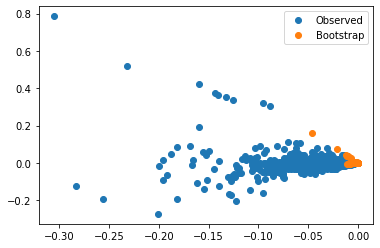

In [58]:
A_res = make_inhomogeneous_rg(Ps[0])
yhat_est = UASE([A_obs,A_est, A_res], d=2, flat=False)

plt.plot(yhat_est[0, :, 0], yhat_est[0, :, 1], 'o', label="Observed", alpha=1)
plt.plot(yhat_est[1, :, 0], yhat_est[1, :, 1], 'o', label="Bootstrap", alpha=1)
# plt.plot(yhat_est[2, :, 0], yhat_est[2, :, 1], 'o', label="Resampled", alpha=1)

plt.legend()